### XGBoost Assignment
Predict whether a person makes over 50K per year or not from classic adult dataset using XGBoost.

### DataSet:
Extraction was done by Barry Becker from the 1994 Census database.

### Attribute Information: 
- Listing of attributes: 
- age: continuous. 
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
- fnlwgt: continuous. 
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
- education-num: continuous. 
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- occupation: Tech-support, Craft-repair, Other-service, Sales, Execmanagerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- sex: Female, Male. 
- capital-gain: continuous. 
- capital-loss: continuous. 
- hours-per-week: continuous. 
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, ElSalvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- wage_class :>50K, <=50K. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
 
from scipy.stats import ttest_ind, ttest_rel
from scipy import stats

import warnings
warnings.filterwarnings("ignore") 
 

In [2]:
train_set = pd.read_csv('adult.data', header = None)
train_set.head().style.background_gradient(cmap='cividis')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
test_set = pd.read_csv('adult.test' , skiprows = 1, header = None)
test_set.head().style.background_gradient(cmap='cividis')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [4]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain',
'capital_loss', 'hours_per_week', 'native_country', 'wage_class']

In [5]:
train_set.columns = col_labels
train_set.head().style.background_gradient(cmap='cividis')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
test_set.columns = col_labels
test_set.head().style.background_gradient(cmap='cividis')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [7]:
# Replace all ' ?' values with nan and drop these missing values
new_train = train_set.replace(' ?',np.nan).dropna()
new_test = test_set.replace(' ?',np.nan).dropna()

In [8]:
print("Shape of the Train data:",new_train.shape)
print("Shape of the Test Data",new_test.shape)

Shape of the Train data: (30162, 15)
Shape of the Test Data (15060, 15)


In [9]:
print(new_train.wage_class.unique())
print(new_test.wage_class.unique())

[' <=50K' ' >50K']
[' <=50K.' ' >50K.']


- In wage_class column of new_test,there is . after 50K, we will handle these things

In [10]:
new_test['wage_class'] = new_test.wage_class.replace({' <=50K.':' <=50K',' >50K.':' >50K'})

In [11]:
print(new_train.wage_class.unique())
print(new_test.wage_class.unique()) 

[' <=50K' ' >50K']
[' <=50K' ' >50K']


In [12]:
# Join new_train and new_test datasets
df = pd.concat((new_train,new_test),axis=0,ignore_index=True)
df.shape

(45222, 15)

In [13]:
df['wage_class']=df['wage_class'].map({' <=50K': 0, ' >50K': 1, ' <=50K.': 0, ' >50K.': 1})
df.head().style.background_gradient(cmap='cividis')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education_num   45222 non-null  int64 
 5   marital_status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital_gain    45222 non-null  int64 
 11  capital_loss    45222 non-null  int64 
 12  hours_per_week  45222 non-null  int64 
 13  native_country  45222 non-null  object
 14  wage_class      45222 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


### From the above observation, we can categorise our Categorical and numerical columns


#### Categorical columns are-
1. workclass
2. education
3. marital_status
4. occupation
5. relationship
6. race
7. sex
8. native_country
9. wage_class

#### Numerical Columns - 
1. age
2. fnlwgt
3. education_num
4. capital_gain
5. capital_loss
6. hours_per_week

#### So, in conclusion, we have 14 independent features and 1 dependent feature
8 categorical features , 6 numerical feature and 1 target feature (wage_class)

In [15]:
# Check for null values
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

- No missing values , let's proceed

In [16]:
df.describe().style.background_gradient(cmap='cividis')

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,wage_class
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,189734.734311,10.118460,1101.430344,88.595418,40.938017,0.247844
std,13.217870,105639.195134,2.552881,7506.430084,404.956092,12.007508,0.431766
min,17.000000,13492.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,117388.250000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,178316.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,237926.000000,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1490400.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [17]:
df.describe(include=["O"]) 


,workclass,education,marital_status,occupation,relationship,race,sex,native_country
count,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
freq,33307,14783,21055,6020,18666,38903,30527,41292


## EDA

#### Count Plot of Categorical features - 

WORKCLASS
                   counts  Percentge
 Private            33307  73.652205
 Self-emp-not-inc    3796   8.394144
 Local-gov           3100   6.855071
 State-gov           1946   4.303215
 Self-emp-inc        1646   3.639821
 Federal-gov         1406   3.109106
 Without-pay           21   0.046438


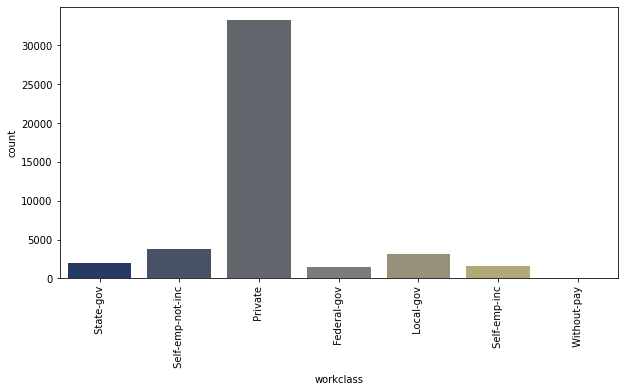

EDUCATION
               counts  Percentge
 HS-grad        14783  32.689841
 Some-college    9899  21.889788
 Bachelors       7570  16.739640
 Masters         2514   5.559241
 Assoc-voc       1959   4.331962
 11th            1619   3.580116
 Assoc-acdm      1507   3.332449
 10th            1223   2.704436
 7th-8th          823   1.819911
 Prof-school      785   1.735881
 9th              676   1.494848
 12th             577   1.275928
 Doctorate        544   1.202954
 5th-6th          449   0.992880
 1st-4th          222   0.490912
 Preschool         72   0.159215


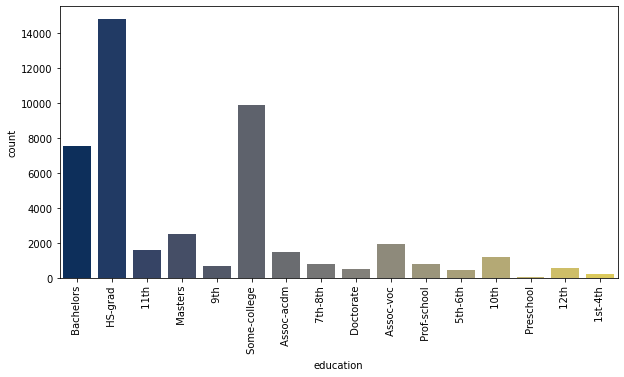

MARITAL_STATUS
                        counts  Percentge
 Married-civ-spouse      21055  46.559197
 Never-married           14598  32.280748
 Divorced                 6297  13.924638
 Separated                1411   3.120163
 Widowed                  1277   2.823847
 Married-spouse-absent     552   1.220645
 Married-AF-spouse          32   0.070762


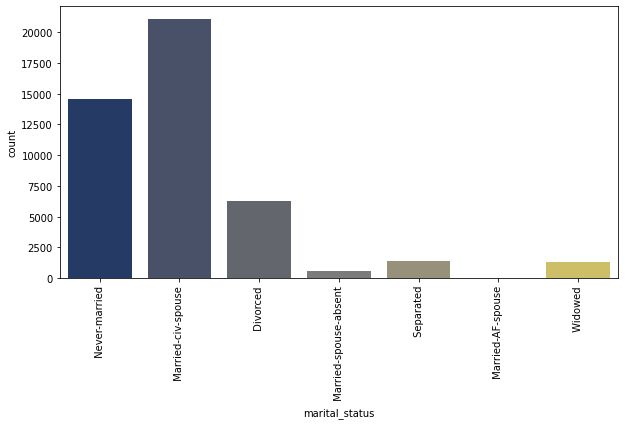

OCCUPATION
                    counts  Percentge
 Craft-repair         6020  13.312105
 Prof-specialty       6008  13.285569
 Exec-managerial      5984  13.232497
 Adm-clerical         5540  12.250674
 Sales                5408  11.958781
 Other-service        4808  10.631993
 Machine-op-inspct    2970   6.567600
 Transport-moving     2316   5.121401
 Handlers-cleaners    2046   4.524347
 Farming-fishing      1480   3.272743
 Tech-support         1420   3.140065
 Protective-serv       976   2.158242
 Priv-house-serv       232   0.513025
 Armed-Forces           14   0.030958


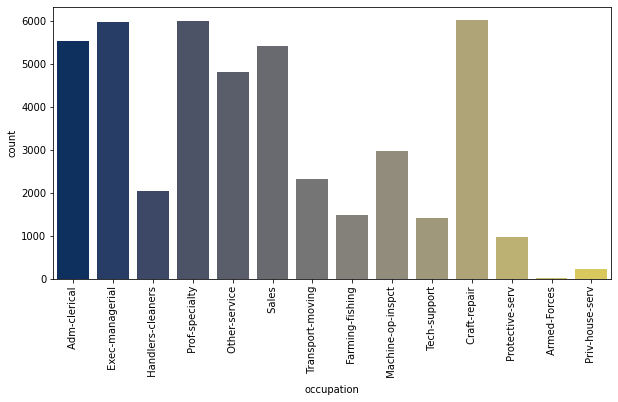

RELATIONSHIP
                 counts  Percentge
 Husband          18666  41.276370
 Not-in-family    11702  25.876786
 Own-child         6626  14.652160
 Unmarried         4788  10.587767
 Wife              2091   4.623856
 Other-relative    1349   2.983061


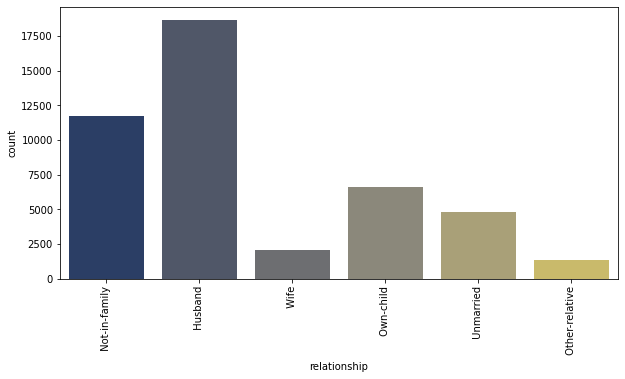

RACE
                     counts  Percentge
 White                38903  86.026713
 Black                 4228   9.349432
 Asian-Pac-Islander    1303   2.881341
 Amer-Indian-Eskimo     435   0.961921
 Other                  353   0.780594


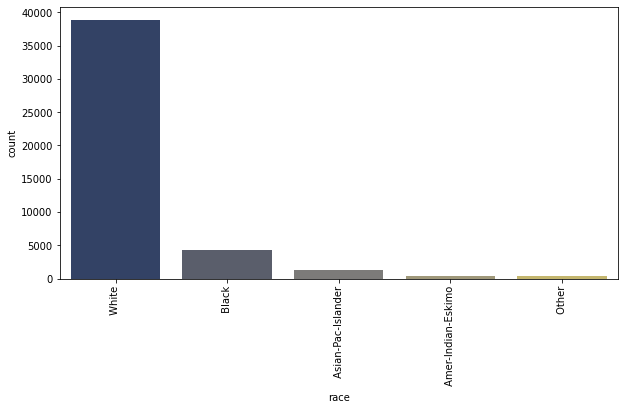

SEX
         counts  Percentge
 Male     30527  67.504754
 Female   14695  32.495246


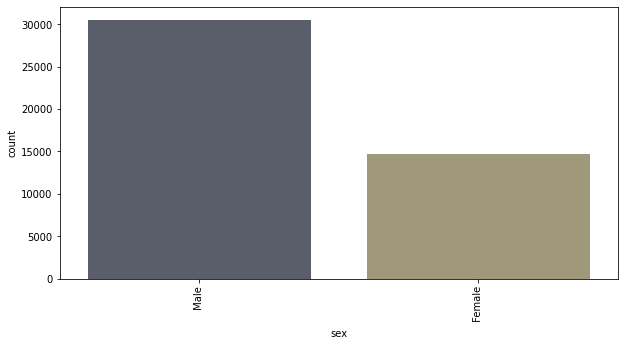

NATIVE_COUNTRY
                             counts  Percentge
 United-States                41292  91.309540
 Mexico                         903   1.996816
 Philippines                    283   0.625802
 Germany                        193   0.426783
 Puerto-Rico                    175   0.386980
 Canada                         163   0.360444
 India                          147   0.325063
 El-Salvador                    147   0.325063
 Cuba                           133   0.294105
 England                        119   0.263146
 China                          113   0.249878
 Jamaica                        103   0.227765
 South                          101   0.223343
 Italy                          100   0.221131
 Dominican-Republic              97   0.214497
 Japan                           89   0.196807
 Guatemala                       86   0.190173
 Vietnam                         83   0.183539
 Columbia                        82   0.181328
 Poland                          81   0.17911

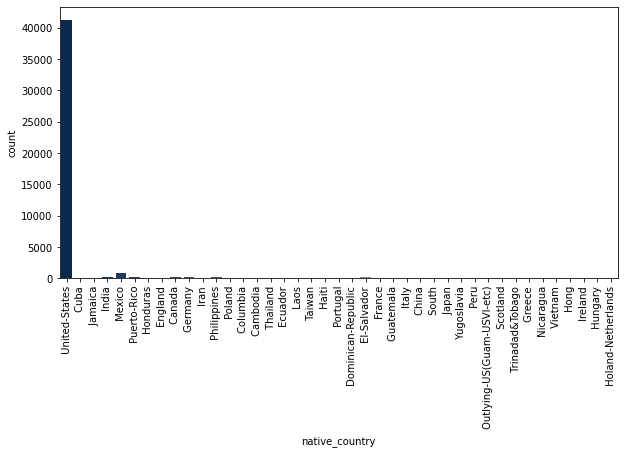

WAGE_CLASS
   counts  Percentge
0   34014  75.215603
1   11208  24.784397


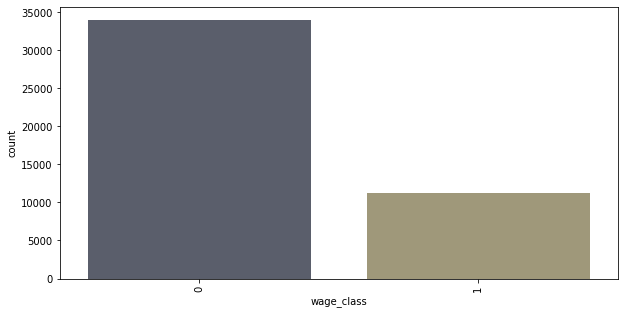

In [18]:
Categorical_Features = ['workclass', 'education','marital_status','occupation','relationship',
                        'race','sex','native_country','wage_class']

for col in Categorical_Features:
        x = pd.DataFrame({"counts":df[col].value_counts(),"Percentge": df[col].value_counts(normalize= True)*100},index=df[col].value_counts().index)
        print(col.upper()) # print column name})
        print(x) # print dataframe
        plt.figure(figsize=(10,5))
        sns.countplot(df[col],palette="cividis")
        plt.xticks(rotation=90)
        plt.show()

### Few observations-
Workclass : Percentage of private category employees was the highest - 73 %, Without-pay was the lowest 0.04 % (very negligible from the graph)

Education: HS-grad had highest number - 32% foloowed by people having some college degree - 21 % and preschool being the lowest

Marital_status: Maximum people had been married to civil spouses -46%, Never Married are 32 %, married to Airforce spouse are the lowest - merely 0.07%

Occupation : There was very close proximity between the Craft -repair (13.31%) and Prof-Speciality (13.28%) . The lowest people were working in the Armed Forces (0.03 %)

Relationship : Husbands earned more - 41%, People who do not stay with the family earn around 25% and wife category earned to the second last 4 %

Race: If we look at the native country statistics, we observe that majority of the people were from US, so in Race category white people were more( 86%) , followed by Black, Asian, American- Indian and others.This dataset is totally biased towards the "white" race.

Sex :, Males were 67% and female count was 32 %

native_country: Maximum people were from US (91% ) followed by Mexico (1.9 %)

Wage_class: People who have <=50K salary are 75% and >=50K are 24%

 

#### Distribution of Numerical Features - 

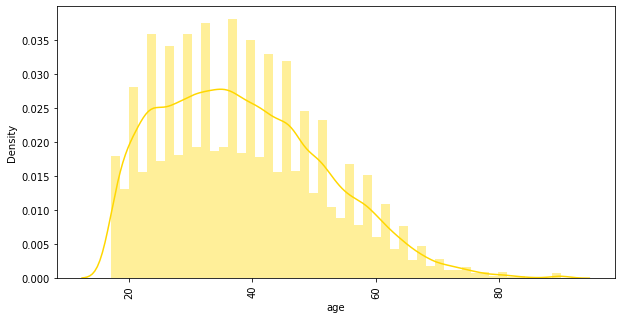

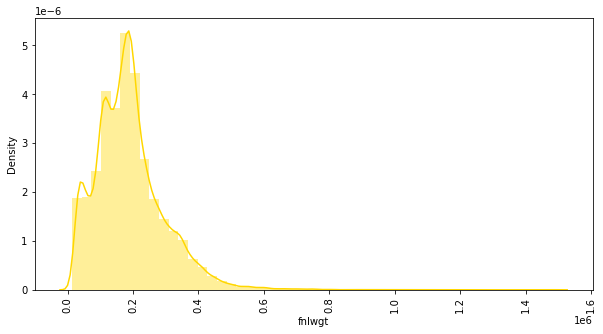

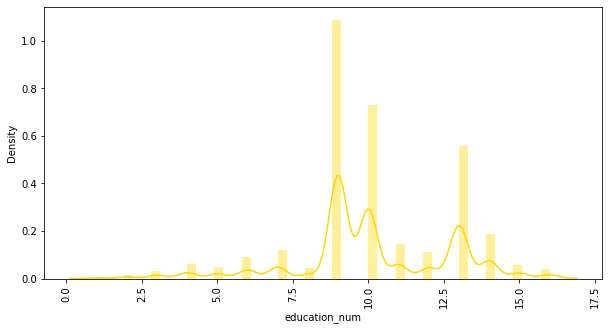

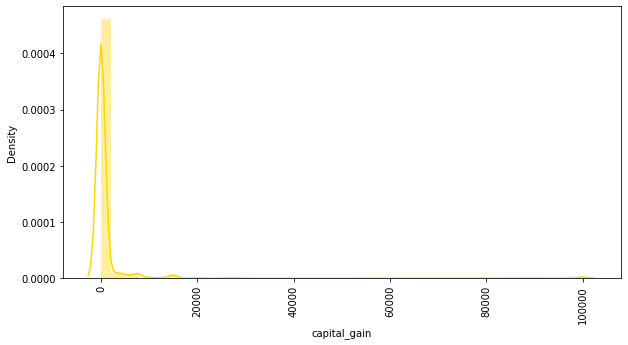

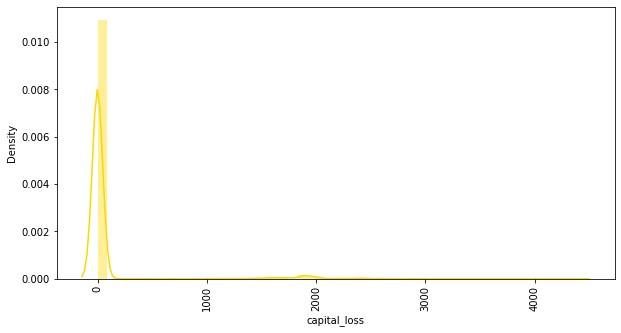

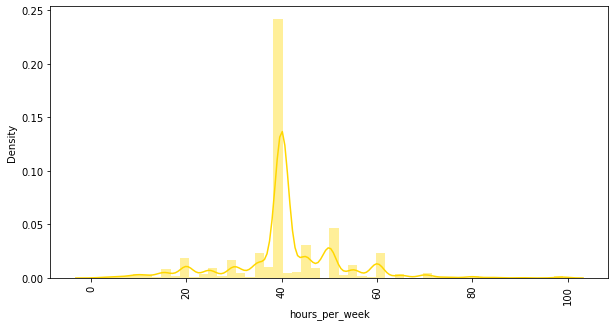

In [19]:
Numerical_Features = ['age', 'fnlwgt','education_num','capital_gain','capital_loss','hours_per_week', ]

for col in Numerical_Features:

        plt.figure(figsize=(10,5))
        sns.distplot(df[col],hist=True,color='gold')
        plt.xticks(rotation=90)
        plt.show()
        

#### Observations on Numerical Features : 

1. Age: Minimum age is around 17 and maximum age is 90 years. People who were in the age-range 20 to 40 worked more, after 40 there was significant drop in the work. People below 20 and above 80 earned <50K. People who were 36 yrs old are 2.83 %.

2. FNLWGT : 21 people had highest number i.e.(0.04%),The distribution of finalweight seems to be rightly skewed since mean(189664.1) is greater than median(178144.5).We will drop this column later

3. Capital Gain - This histogram shows that most of the "capital-gain" values are centered on 0 and few on 10k and 99k.
capital-gain is concentrated on the one particular value and other are spread with large standard deviation(7452.01).
capital-gain shows that either a person has no gain or has gain of very large amount(10k or 99k).

4. Capital Loss- This histogram shows that most of the "capital-loss" values are centered on 0 and only few are non zero(2282).This attribute is similar to the capital-gain i.e. most of the values are centered on 0(nearly 43000 of them)

5. Hours per Week - Most people worked for 40 hrs in a week (47%), followed by 50 (9%) and 45 (5.75%)

### Relationship between Capital Gain and Capital Loss

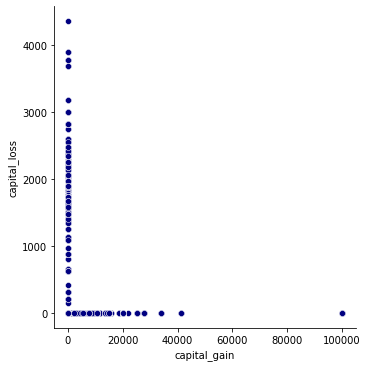

In [20]:
sns.relplot('capital_gain','capital_loss', data= df,color='navy')
plt.xlabel("capital_gain")
plt.ylabel("capital_loss")
plt.show()

#### Possibilities for capital gain and capital loss

- Both capital gain and capital loss can be zero
- If capital.gain is zero there is possibility of capital loss being high or above zero.
- If capital loss is zero there is possibility of capital.gain being high or above zero.
- With the help of this, we can do one modification later(i.e. capital-change = capital-gain - capital-loss])

### Bivariate analysis

#### 1. Wage_Class Vs Age

In [21]:
# First we will find out the Mean age of people who were earning >50K and <=50K
df[['wage_class', 'age']].groupby(['wage_class'], as_index=False).mean().sort_values(by='age', ascending=False)

,wage_class,age
1,1,44.006067
0,0,36.749427


- Mean Age for people earning wage >50K is 44 yrs and for <=50K is 36.7 yrs

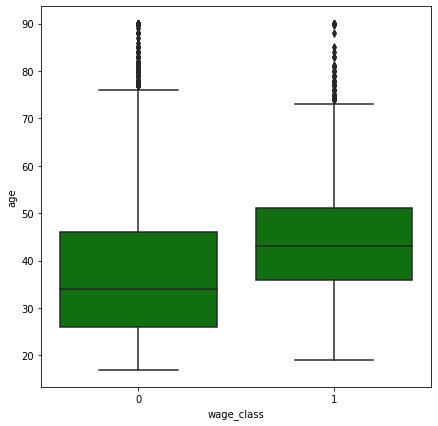

In [22]:
fig = plt.figure(figsize=(7,7)) 
sns.boxplot(x="wage_class", y="age", data=df,color='g')
plt.show()

#### The above bivariate boxplot shows :

Outliers are present in both the Wage group(<=50k and >50k) wrt "age" attribute.
Wage group(<=50k) has lower median "age"(34 years) than the Wage group(>50k) which has median "age"(42 years).

Interquartile range(IQR) :
- For Wage group(<=50k) , IQR is between [25,46] (long range)
- Middle 50% of the Age is spread over longer range for the income group who earn <=50k.
- For Wage group(>50k) , IQR is between [38,50] (shorter range)

### Let's do few hypothesis tests on this dataset -
### 1. Hypothesis Test 1 -
- Null Hypothesis :- There is no difference in Mean age of Wage group >50k and Wage group <=50k.
- Alternate Hypothesis :- There is difference in Mean age of Wage group >50k and Wage group <=50k.

In [23]:
import random

df = df[(np.abs(stats.zscore(df["age"])) < 3)] 

wage_1 = df[df['wage_class']==1]['age']
wage_0 = df[df['wage_class']==0]['age']

wage_0 = wage_0.values.tolist()
wage_0 = random.sample(wage_0, 100)
wage_1 = wage_1.values.tolist()
wage_1 = random.sample(wage_1, 100)

In [24]:
from scipy.stats import ttest_ind
ttest,pval = ttest_ind(wage_1,wage_0,equal_var = False)
print("ttest: ",ttest)
print('p value: ',pval)


if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We accept null hypothesis")

ttest:  2.65895934706154
p value:  0.008545919836347596
We reject null hypothesis


### Conclusion - 
We can conclude that there is a significant difference in the mean ages of Wage group >50k and Wage group <=50k.
It means that age has some contribution to distinguish Wage groups.

#### 2. hours_per_week Vs wage_class

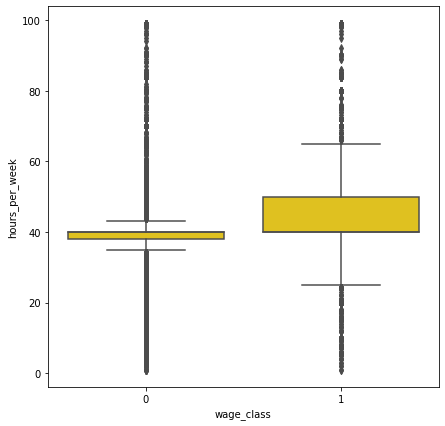

In [25]:
fig = plt.figure(figsize=(7,7)) 
sns.boxplot(x="wage_class", y="hours_per_week", data=df,color='gold')
plt.show()

- The median "hours-per-week" for Wage group who earned >50k is greater than the Wage group who earns <=50k.

#### Interpretation


- Wage group who earns <=50k has spent ~37 "hours-per-week".
- Wage group who earns >50k has spent ~44 "hours-per-week".(long hours)

- The boxplot for Wage group who earned <=50k has small range for minimum (q1-1.5 IQR) and maximum (q3+ 1.5 IQR) i.e.
~[28,48].But the boxplot for Wage group who earns >50k has large range for minimum (q1-1.5 IQR) and maximum (q3+ 1.5 IQR) i.e. ~[23,68].

#### Interpretation

- Wage group who earned >50k have flexible working hours

- More Outliers present in the Wage group who earned <=50k.

### 1. Hypothesis Test 2 -
- Null Hypothesis :- There is no difference in Mean of income group >50k and income group <=50k.
- Alternate Hypothesis :- There is difference in Mean of income group >50k and income group <=50k.

In [26]:
df = df[(np.abs(stats.zscore(df["hours_per_week"])) < 3)] 

wage_1 = df[df['wage_class']==1]["hours_per_week"]
wage_0 = df[df['wage_class']==0]["hours_per_week"]

wage_0 = wage_0.values.tolist()
wage_0 = random.sample(wage_0, 100)
wage_1 = wage_1.values.tolist()
wage_1 = random.sample(wage_1, 100)

ttest,pval = ttest_ind(wage_1,wage_0,equal_var = False)
print("ttest : ",ttest)
print('p value : ',format(pval, '.70f'))

if pval <0.05:
    print("We reject null hypothesis")
else:
    print("We accept null hypothesis")

ttest :  5.542380594658865
p value :  0.0000000951960198038019774583674468236560439748927819891832768917083740
We reject null hypothesis


#### Conclusion-
We can conclude that there is difference in Mean of wage group >50k and wage group <=50k.
It means that hours-per-week has some contribution to distinguish wage groups.

### Label Encoding

In [27]:
for column in df:
    enc=LabelEncoder()
    if df.dtypes[column]==np.object:
         df[column]=enc.fit_transform(df[column])

In [28]:
df.head().style.background_gradient(cmap='cividis')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


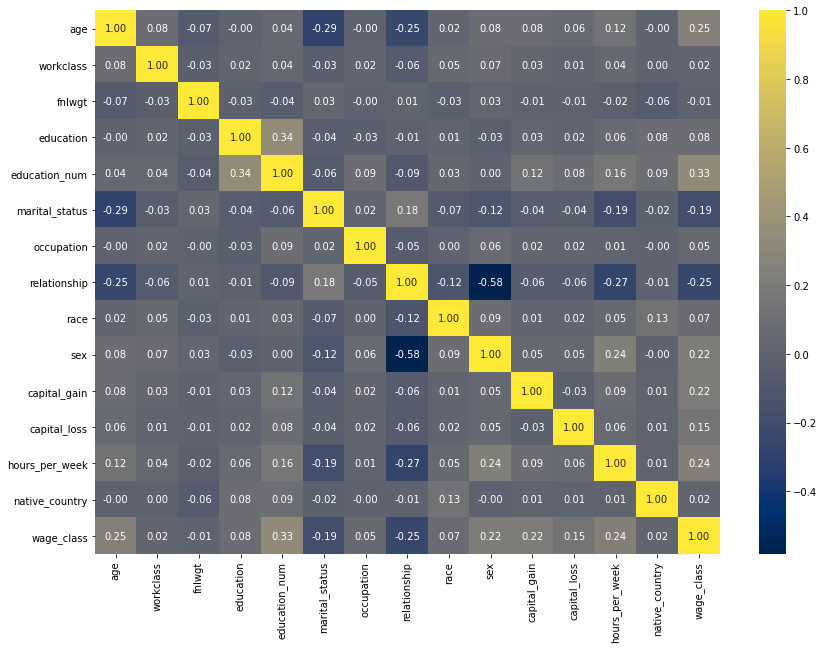

In [29]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(),cmap="cividis",annot=True,fmt='.2f')
plt.show()

- From the above heatmap, education and education_num are correlated,so we will drop the education column.
- We will drop relationship column and keep marital status
- Furthermore,"fnlwgt" is not useful to us as it refers to only the sampling in the census conducted and has no practical effect on the label.
- Also we drop the "native.country" as more are from single country(USA) which can cause bias. 

In [30]:
df=df.drop(['education','relationship','occupation','fnlwgt','native_country'],axis=1)

In [31]:
df.head().style.background_gradient(cmap='cividis')

,age,workclass,education_num,marital_status,race,sex,capital_gain,capital_loss,hours_per_week,wage_class
0,39,5,13,4,4,1,2174,0,40,0
1,50,4,13,2,4,1,0,0,13,0
2,38,2,9,0,4,1,0,0,40,0
3,53,2,7,2,2,1,0,0,40,0
4,28,2,13,2,2,0,0,0,40,0


In [32]:
X =  df.drop('wage_class',axis=1)
y =  df['wage_class']

In [33]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(X)

In [34]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(scaled_data,y,test_size=0.3,random_state=42)

In [35]:
# fit model on training data
import xgboost as xgb
from xgboost import XGBClassifier
model = XGBClassifier(objective='binary:logistic',eval_metric= "logloss")
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [36]:
# cheking Train and Test accuracy
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
print("Train Accuracy:",accuracy_score(y_train,y_train_predict))
print("Test Accuracy: ",accuracy_score(y_test,y_predict))

Train Accuracy: 0.8788824873668287
Test Accuracy:  0.8651246620606788


In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
param_grid={
   
    'learning_rate':[1,0.5,0.1,0.01,0.001],
    'max_depth': [3,5,10,20],
    'n_estimators':[10,50,100,200]
    
}

In [39]:
grid= GridSearchCV(XGBClassifier(objective='binary:logistic',eval_metric = "logloss"),param_grid, verbose=3)

In [40]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END ..learning_rate=1, max_depth=3, n_estimators=10; total time=   0.0s
[CV 2/5] END ..learning_rate=1, max_depth=3, n_estimators=10; total time=   0.0s
[CV 3/5] END ..learning_rate=1, max_depth=3, n_estimators=10; total time=   0.0s
[CV 4/5] END ..learning_rate=1, max_depth=3, n_estimators=10; total time=   0.0s
[CV 5/5] END ..learning_rate=1, max_depth=3, n_estimators=10; total time=   0.0s
[CV 1/5] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   0.1s
[CV 2/5] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   0.1s
[CV 3/5] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   0.1s
[CV 4/5] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   0.1s
[CV 5/5] END ..learning_rate=1, max_depth=3, n_estimators=50; total time=   0.1s
[CV 1/5] END .learning_rate=1, max_depth=3, n_estimators=100; total time=   0.3s
[CV 2/5] END .learning_rate=1, max_depth=3, n_e

[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=10; total time=   0.0s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=10; total time=   0.0s
[CV 4/5] END learning_rate=0.5, max_depth=5, n_estimators=10; total time=   0.0s
[CV 5/5] END learning_rate=0.5, max_depth=5, n_estimators=10; total time=   0.0s
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=50; total time=   0.3s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=50; total time=   0.2s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=50; total time=   0.2s
[CV 4/5] END learning_rate=0.5, max_depth=5, n_estimators=50; total time=   0.2s
[CV 5/5] END learning_rate=0.5, max_depth=5, n_estimators=50; total time=   0.3s
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=100; total time=   0.4s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=100; total time=   0.5s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=100; total time=   0.4s
[CV 4/5] END learning_rat

[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=10; total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=10; total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.8s
[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.7s
[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.9s
[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.6s
[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=10, n_estimators=100; total time=   1.5s
[CV 2/5] END learning_rate=0.1, max_depth=10, n_estimators=100; total time=   1.3s
[CV 3/5] END learning_rate=0.1, max_depth=10, n_estimators=100; total time=   1.2s
[CV 4/5] END learning_rate=0.1, max_depth=10, n_estimators=100; total time=   1.3s
[CV 5/5] END learning_rate=0.1, max_depth=10, n_estimators=100; total time=   1.2s
[CV 1/5] EN

[CV 4/5] END learning_rate=0.01, max_depth=20, n_estimators=10; total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=20, n_estimators=10; total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=20, n_estimators=50; total time=   1.6s
[CV 2/5] END learning_rate=0.01, max_depth=20, n_estimators=50; total time=   1.5s
[CV 3/5] END learning_rate=0.01, max_depth=20, n_estimators=50; total time=   1.3s
[CV 4/5] END learning_rate=0.01, max_depth=20, n_estimators=50; total time=   1.3s
[CV 5/5] END learning_rate=0.01, max_depth=20, n_estimators=50; total time=   1.6s
[CV 1/5] END learning_rate=0.01, max_depth=20, n_estimators=100; total time=   3.3s
[CV 2/5] END learning_rate=0.01, max_depth=20, n_estimators=100; total time=   2.9s
[CV 3/5] END learning_rate=0.01, max_depth=20, n_estimators=100; total time=   3.7s
[CV 4/5] END learning_rate=0.01, max_depth=20, n_estimators=100; total time=   2.9s
[CV 5/5] END learning_rate=0.01, max_depth=20, n_estimators=100; total time=   2.8s

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
             

In [41]:
# To  find the parameters giving maximum accuracy
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [42]:
# Create new model using the same parameters
new_model=XGBClassifier(learning_rate=0.1, max_depth= 5, n_estimators= 200,objective='binary:logistic',eval_metric = "logloss")
new_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [43]:
# Check train and Test accuracy of new model
y_predict_new = new_model.predict(X_test)
y_train_predict_new = new_model.predict(X_train)
print("Train Accuracy:",accuracy_score(y_train,y_train_predict_new))
print("Test Accuracy: ",accuracy_score(y_test,y_predict_new))
 

Train Accuracy: 0.8730245582413338
Test Accuracy:  0.8671522979873836


In [44]:
y_pred_data = pd.DataFrame({'Actual Wage Group':y_test,'Predicted Wage Group':y_predict_new,'Difference':y_test-y_predict_new})
y_pred_data[0:5].style.background_gradient(cmap='cividis')

,Actual Wage Group,Predicted Wage Group,Difference
15799,0,0,0
34666,0,0,0
17517,1,1,0
23958,1,0,1
16734,1,1,0
